In [629]:
import pandas as pd
filename = r'C:\tmp\data\Nanopore data Waad Tombo files\Own601-data\barcode10CP10.xlsx'
# filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode04_Waad601.xlsx'
# filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode05_WaadR1.xlsx'
# filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode06_WaadR2.xlsx'

df = pd.read_excel(filename)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown']

In [630]:
# discard reads that lack more than X bps on either end

X = 200
start = len(df.columns)
df = df.loc[:, ~(df.iloc[:X].isna().all() | df.iloc[-X:].isna().all())]
print(start, " > ",  len(df.columns))

838  >  575


In [631]:
# Compute compound LLR by summing over a window of 147 bp; normalize by number of potential methylation sites in window

from tqdm import tqdm
import numpy as np

window = 147
llr_df = df.copy()

for col in tqdm(df.columns):
    llr_df[col] = np.roll(df[col].rolling(window=window, min_periods=1).sum() / df[col].rolling(window=window, min_periods=1).count(), -window//2)

# discard values at the end of the chromosome
llr_df[ df.index > len(df) - window//2] = np.nan


  0%|          | 0/575 [00:00<?, ?it/s]

100%|██████████| 575/575 [00:04<00:00, 121.81it/s]


In [632]:
# Convert LLR to probability to nulcesomse occupancy using Vanderlick's formula
# https://doi.org/10.1103/PhysRevA.34.5130
# LLR should be converted to a free energy landscape, using DeltaG for nucleosome formation 

import numpy as np

def vanderlick(llr, multiplier = -1, delta_g=10, handles = 1000, convolve = 147, energy_landscape = None):

    llr = np.concatenate([np.zeros(handles), llr, np.zeros(handles)])
    llr = np.nan_to_num(llr)
    n = len(llr)
    
    if energy_landscape is None:
        energy_landscape = llr*multiplier + delta_g
    footprint = 147

    forward = np.zeros(n)
    for i in range(n):
        tmp = sum(forward[ max( i - footprint , 0):i])
        forward[i] = np.exp(-energy_landscape[i] - tmp)

    backward = np.zeros(n)
    r_forward = forward[::-1]
    for i in range(n):
        backward[i] = 1 - sum(r_forward[max(i - footprint , 0):i]* backward[max(i - footprint,0):i])

    P = forward * backward[::-1]

    if convolve >1:
        kernel = np.ones(convolve)/convolve
        P = convolve*np.convolve(P, kernel, mode='same')
        P = np.clip(P, 0, 1)
    return P[handles:-handles]

In [742]:
# randomly select a couple of reads

selected = df.columns[np.random.randint(0, len(df.columns), len(colors))]

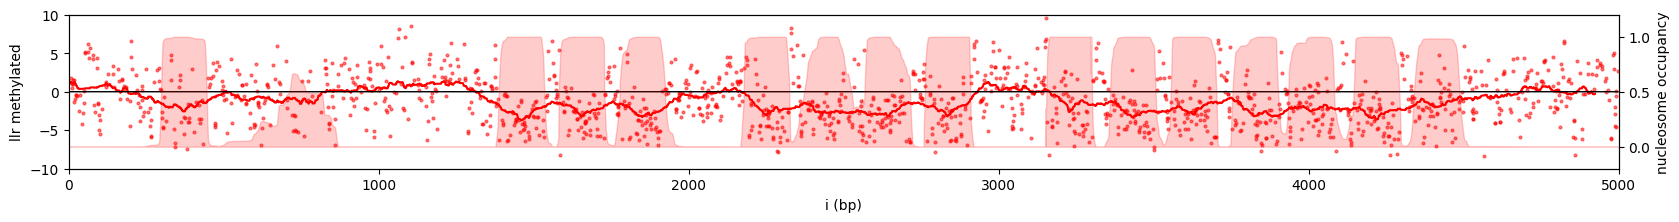

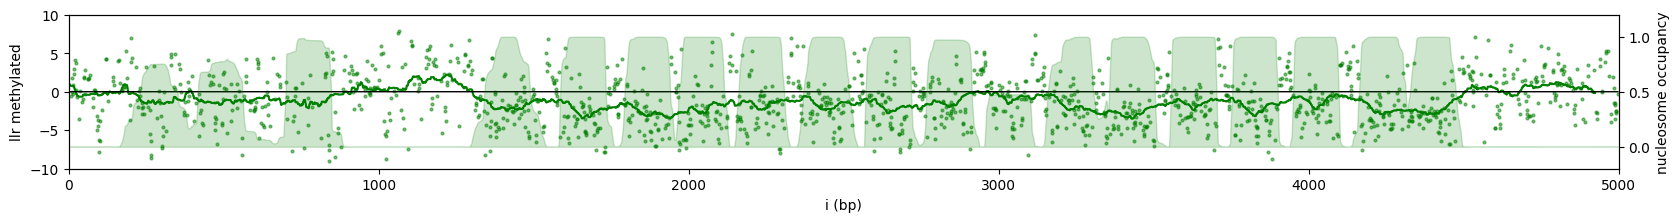

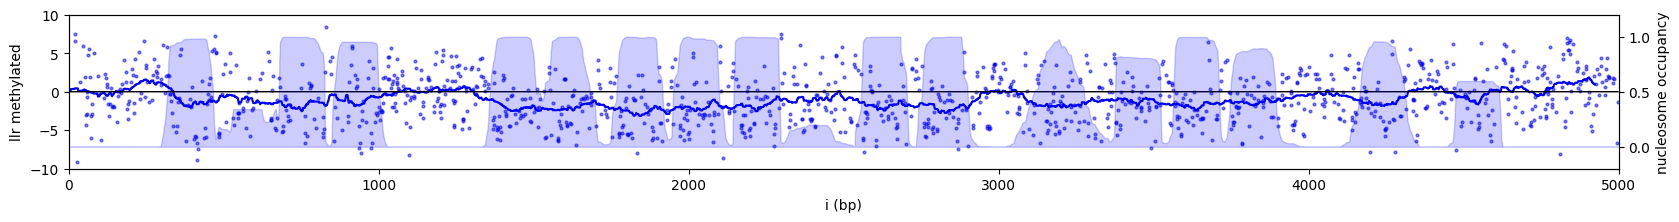

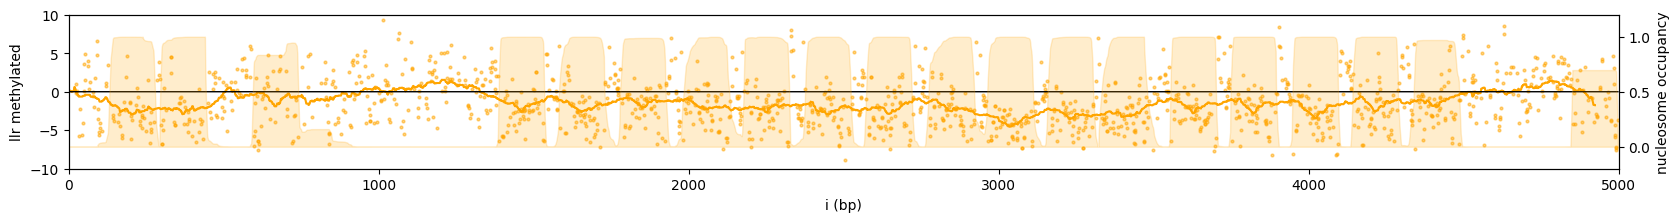

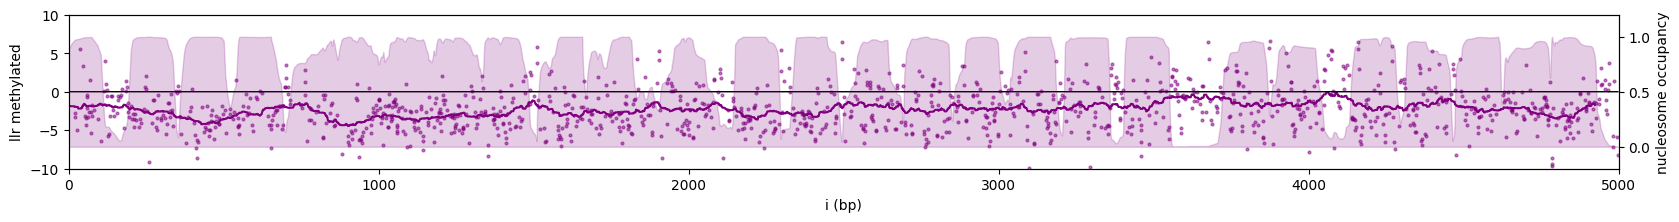

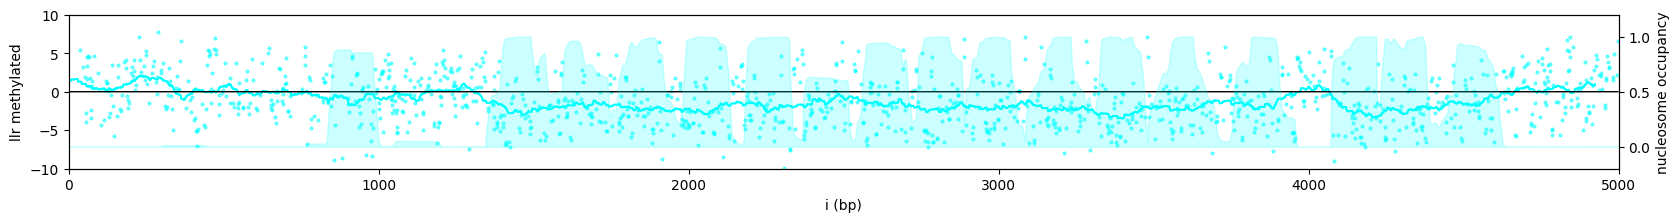

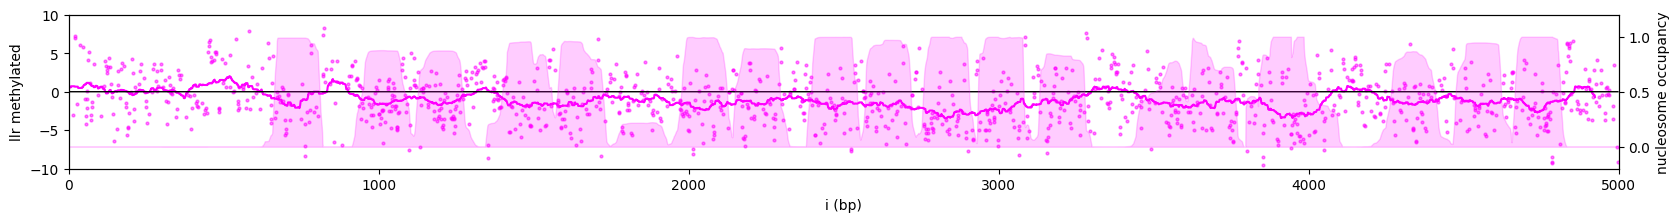

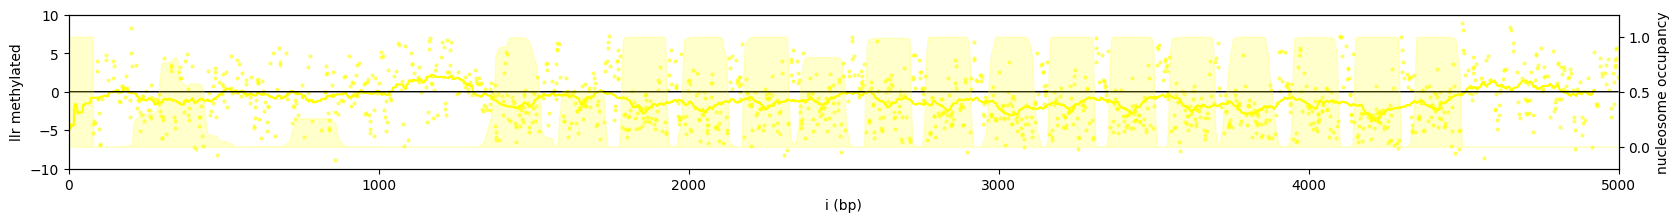

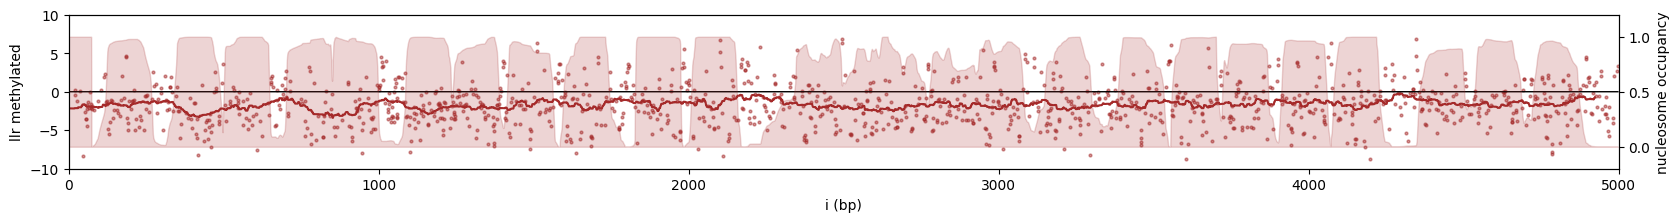

In [743]:
# Plot a couple of examples

dg = 15
multiplier = -8
xlim = [0, 5000]
base_index = np.arange(len(llr_df))

for i, c in enumerate(selected):
    fig, ax1 = plt.subplots()
    # plot log likelihood ratio of methylation; not absence of methylation
    ax1.plot(-df[c], 'o', markersize=2, alpha=0.5, color = colors[i])
    ax1.plot(-llr_df[c],color = colors[i])
    ax1.plot(np.zeros(len(llr_df[c])), color = 'black', linewidth = 1)
    # ax1.plot(-1.8*np.ones(len(llr_df[c])), '--', color = 'black', linewidth = 1)
    ax1.set_ylabel(f'llr methylated')
    ax1.set_ylim(-10, 10)
    plt.xlabel('i (bp)')
    plt.xlim(*xlim)
    ax2 = ax1.twinx()
    ax2.fill_between(base_index, vanderlick(llr_df[c], multiplier = multiplier, delta_g = dg, convolve=window), color = colors[i], alpha = 0.2)
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_ylabel(f'nucleosome occupancy')
    plt.gcf().set_size_inches(20, 2)
    plt.show()

In [720]:
# Convert LLR to nucleosome occupancy

nuc_df = llr_df.copy()
for c in tqdm(llr_df.columns):
    nuc_df[c] = vanderlick(llr_df[c], multiplier = multiplier, delta_g = dg, convolve = window)

100%|██████████| 575/575 [02:09<00:00,  4.43it/s]


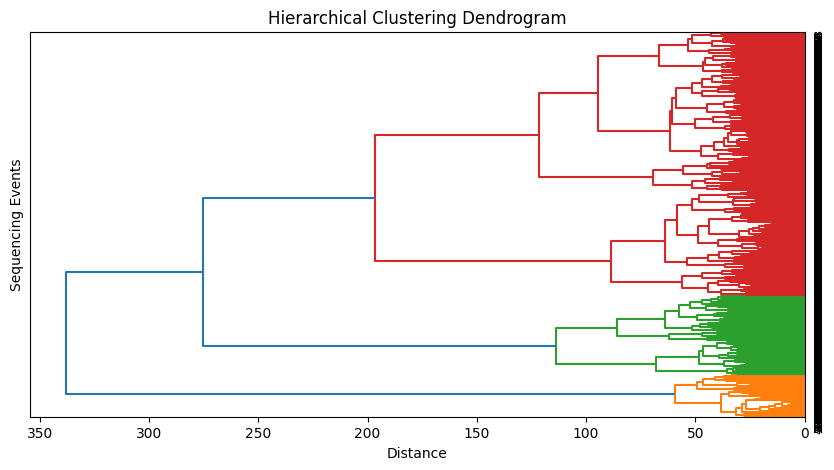

In [721]:
# Compute dendogram

from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(nuc_df[window:].T, method='ward')

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Sequencing Events')
dendrogram(Z, orientation='left', leaf_rotation=90., leaf_font_size=8.)
plt.show()

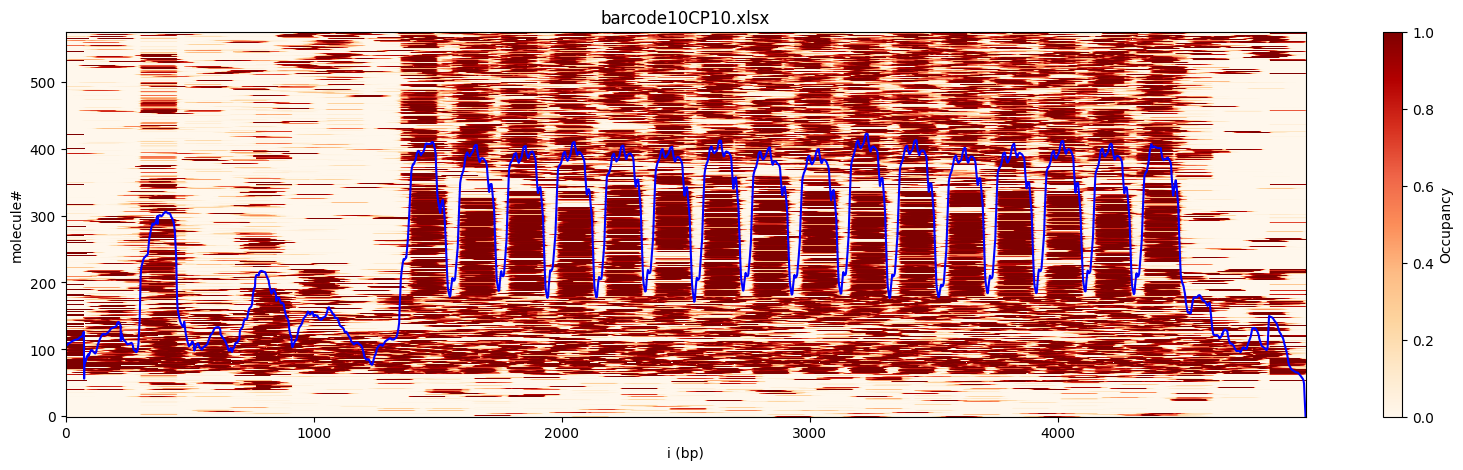

In [722]:
# plot the nucleosome occupancy matrix, ordered by the dendogram

clustering_order = dendrogram(Z, no_plot=True)['leaves']

df_reordered = nuc_df.iloc[:, clustering_order]

im = plt.imshow(df_reordered.swapaxes("index", "columns"), cmap='OrRd', interpolation='nearest', vmin=0, vmax=1, origin='lower', aspect = 'auto')
plt.ylabel(f'molecule#')
plt.xlabel('i (bp)')
cbar = plt.colorbar(im)
cbar.set_label('Occupancy', rotation=90)
plt.plot(len(nuc_df.columns)*nuc_df.mean(axis=1), color='blue', linewidth=1.5)
plt.title(filename.split('\\')[-1])
plt.gcf().set_size_inches(20, 5)

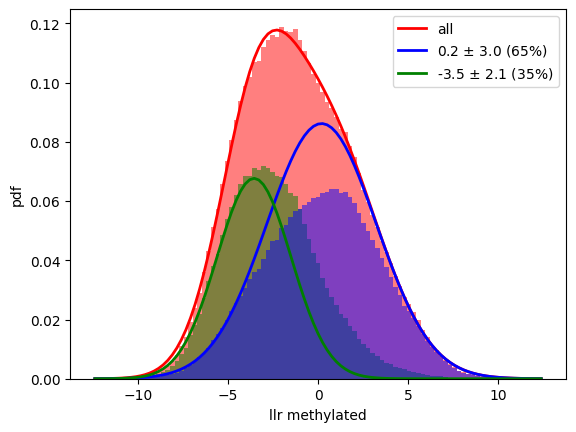

In [725]:
# statistics of methylation, no nucleosome windowing

from scipy.optimize import curve_fit

def double_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
    return a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) + a2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))

selection = [nuc_df >0, nuc_df > 0.5, nuc_df < 0.5]
p0=[0.2, -2, 2, 0.3, 1, 2]

edges = np.linspace(-12.5, 12.5, 100)
bins = (edges[:-1] + edges[1:])/2
for i, s in enumerate(selection):
    hist, _ = np.histogram(-df[s].fillna(-10000), bins=edges)
    if i == 0:
        normalization = np.sum(hist) * (bins[1]-bins[0])
        p, pcov = curve_fit(double_gaussian, bins, hist/normalization, p0=p0)
        fraction = p[0]*p[2] / (p[0]*p[2] + p[3]*p[5])
        plt.plot(bins, double_gaussian(bins, *p), color = colors[i], linewidth=2, label = 'all')
        plt.plot(bins, double_gaussian(bins, *(p*np.asarray([0,1,1,1,1,1]))), color = colors[2], linewidth=2, label = f'{p[4]:.1f} $\pm$ {p[5]:.1f} ({1-fraction:.0%})')
        plt.plot(bins, double_gaussian(bins, *(p*np.asarray([1,1,1,0,1,1]))), color = colors[1], linewidth=2, label = f'{p[1]:.1f} $\pm$ {p[2]:.1f} ({fraction:.0%})')
    plt.bar(bins, hist/normalization, color = colors[i], alpha=0.5, align='center', width=bins[1]-bins[0])
    
plt.xlabel('llr methylated')
plt.ylabel('pdf')
plt.legend()
plt.show()

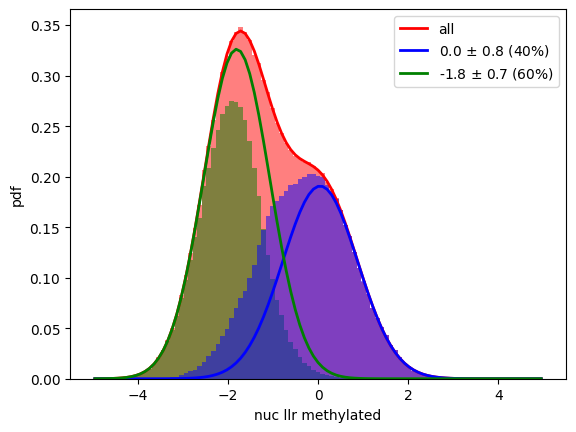

In [726]:
# statistics of methylation, with nucleosome windowing

p0=[0.25, -2, 1, 0.2, 0, 1]
edges = np.linspace(-5, 5, 100)
bins = (edges[:-1] + edges[1:])/2
for i, s in enumerate(selection):
    hist, _ = np.histogram(-llr_df[s].fillna(-10000), bins=edges)
    if i == 0:
        normalization = np.sum(hist) * (bins[1]-bins[0])
        p, pcov = curve_fit(double_gaussian, bins, hist/normalization, p0=p0)
        fraction = p[0]*p[2] / (p[0]*p[2] + p[3]*p[5])
        plt.plot(bins, double_gaussian(bins, *p), color = colors[i], linewidth=2, label = 'all')
        plt.plot(bins, double_gaussian(bins, *(p*np.asarray([0,1,1,1,1,1]))), color = colors[2], linewidth=2, label = f'{p[4]:.1f} $\pm$ {p[5]:.1f} ({1-fraction:.0%})')
        plt.plot(bins, double_gaussian(bins, *(p*np.asarray([1,1,1,0,1,1]))), color = colors[1], linewidth=2, label = f'{p[1]:.1f} $\pm$ {p[2]:.1f} ({fraction:.0%})')
    plt.bar(bins, hist/normalization, color = colors[i], alpha=0.5, align='center', width=bins[1]-bins[0])
    
plt.xlabel('nuc llr methylated')
plt.ylabel('pdf')
plt.legend()
plt.show()